In [1]:
import sys
sys.path.append("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/")

In [2]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics
from collections import Counter

%matplotlib inline

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [3]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [4]:
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field", " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm", "long short-term memory", "generative adversarial network", "theano", "neural network", "deep belief net", "boltzmann machine", "convnet", "deep reinforcement learning", "deep neural network", " dnn ", " dnn-", "multilayer perceptron", "autoencoder", "auto-encoder", "activation function", "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent", "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", "connectionist"]

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [5]:
def faculty_at_institution(institution_name, asst_faculty):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## General trend in deep-learning research

In [6]:
def distribution(asst_faculty, keywords):
    yearly_rate = Counter()
    for f in asst_faculty:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in keywords):
                    yearly_rate[pub['year']] += 1
                
    return yearly_rate 

dist = distribution(asst_faculty, deep_learning_keywords)

/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


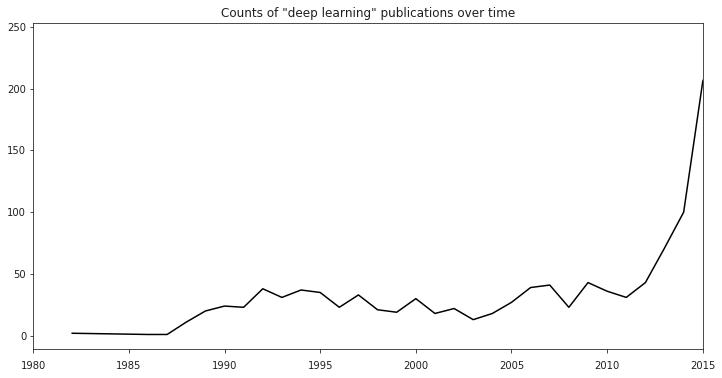

In [7]:
x = dict(dist).keys(); y = [];
for year, count in dict(dist).items():
    y.append(count)
    
plt.figure(figsize=(12,6))
plt.plot(x, y, color = 'k')
plt.xlim(1980, 2015)
plt.title('Counts of "deep learning" publications over time')
plt.show()

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [8]:
place = 'University of Colorado, Boulder'

In [9]:
def get_hires_and_publications(place, keywords, asst_faculty):
    hires_and_publications = []
    for f in faculty_at_institution(place, asst_faculty):
        person = {"facultyName": f.facultyName}
    
        person["start"] = 2020; person["end"] = 0;
        for job in f.faculty:
            if job['place'] == place and not (job['start_year'] is None):
                person["start"] = min(job['start_year'], person["start"])
                person["end"] = max(job['end_year'], person["end"])
    
        if person["end"] == 0:
            person["end"] = 2011
        if person["start"] == 2020:
            continue
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any((pub['title'].lower().count(keyword) > 0) for keyword in keywords): #or relevant_venue:
                    #print(pub['title'])
                    relevant_pubs.append(pub['year'])
                        
        person["pubs"] = relevant_pubs
    
        hires_and_publications.append(person)
    
    return hires_and_publications

Let's plot the above data so we can better see when hires and publications occurred.

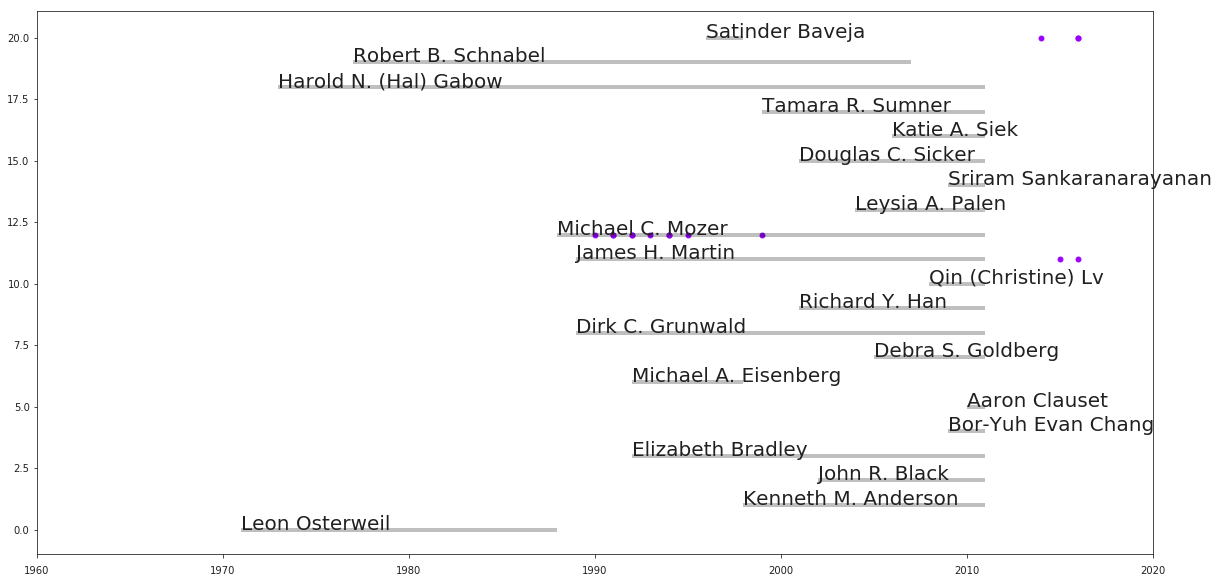

In [10]:
def plot_careers(place, keywords, asst_faculty):
    i = 0
    plt.figure(figsize=(20,10))
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        #print person['facultyName']
        plt.plot([person["start"], person["end"]], [i, i], linewidth= 4, color = 'k', alpha = .25)
        plt.text(person["start"], i, person["facultyName"], fontsize=20)
    
        if len(person['pubs']) > 0:
            plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 24, color = [153.0/255.0, 0.0/255.0, 255.0/255.0])
        i += 1

    plt.xlim(1960, 2020)

plot_careers(place, deep_learning_keywords, asst_faculty)

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

In [11]:
def find_infected_hire(place, keywords, asst_faculty):
    '''
    Returns None if no infected hire found, otherwise the first hire
    is returned as (person, year of infectious publication).
    '''
    candidates = []
    for person in get_hires_and_publications(place, keywords, asst_faculty):
        person_pubs = person["pubs"]
        # If we do not know the faculty member's start date, or they have no pubs
        if not person["start"] or len(person_pubs) == 0:
            continue
        
        # Consider the publications when the entry was a professor at the institution
        person_pubs = filter(lambda x: person["start"] <= x <= person["end"], person_pubs)
        if person_pubs:
            candidates.append((person, person_pubs))
    
    # If the university was never "infected"
    if not candidates:
        return None
    else:
        return min(candidates, key=lambda xs: min(xs[1]))
        
print "\nWas a \"deep-learning\" researcher hired who might have led to the research area? {0}".format(find_infected_hire(place, deep_learning_keywords, asst_faculty))


Was a "deep-learning" researcher hired who might have led to the research area? ({'pubs': [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990], 'start': 1988, 'facultyName': 'Michael C. Mozer', 'end': 2011}, [1999, 1995, 1994, 1994, 1993, 1992, 1992, 1991, 1991, 1990])


In [12]:
def is_infected_hire(person, delta_t):
    return any([(pub - person[0]["start"]) <= delta_t for pub in person[0]["pubs"]])

In [13]:
print "Was the person who infected CU Boulder (Mike Mozer), infected by hiring? {0}".format(is_infected_hire(find_infected_hire(place, deep_learning_keywords, asst_faculty), 2))

Was the person who infected CU Boulder (Mike Mozer), infected by hiring? True


## For all universities

In [14]:
def percent_has_relevant_prior_pubs(delta_t, keywords, asst_faculty):
    n_no_priors = 0
    n_yes_priors = 0
    total = 0
    # Go through every institution
    for place in inst.keys():
        if place == "UNKNOWN" or place == "All others":
            continue
            
        # Look for the faculty member which has infected the institution 
        infected_hire = find_infected_hire(place, keywords, asst_faculty)
        if not infected_hire:
            continue
        
        # Were they publishing on deep-learning before their hire date?
        if is_infected_hire(infected_hire, delta_t):
            n_yes_priors += 1
        else:
            n_no_priors += 1
        total += 1
    
    print("Hires with no background in topic: {0}, Hires with background in topic: {1}, Total infected univesities: {2}".format(n_no_priors, n_yes_priors, total))
    return (float(n_no_priors)/total, float(n_yes_priors)/total)

In [15]:
topic_modeling_keywords = ["probabilistic latent semantic analysis", "plsa", "latent dirichlet allocation",
                           "latent semantic analysis", "latent semantic indexing", "topic model", 
                           "probabilistic topic modeling"]
incremental_keywords = ["incremental computation", "self-adjusting computation", "program derivative","dbtoaster",
                        "incremental view", "partial evaluation", "incremental computing",
                        "incrementally compute", "frtime", "adaptive functional programming", "delta ml", 
                        "haskell adaptive", "cornell synthesizer generator", "icedust", "adapton", 
                        "one-way dataflow constraints", "reactive computation", "differential dataflow",
                        "jane street incremental", "incremental datalog", "incremental prolog", 
                        "incremental type checking", "self-adjusting"]
deep_learning_keywords = ["convolutional net", "convolutional neural net", "convolutional neural field",
                         " rnn ", "deep learning", "deep-learning", "recursive neural net", "lstm",
                         "long short-term memory", "generative adversarial network", "theano",
                         "neural network", "deep belief net", "boltzmann machine", "convnet",
                         "deep reinforcement learning", "deep neural network", " dnn ", " dnn-",
                         "multilayer perceptron", "autoencoder", "auto-encoder", "activation function",
                         "backprop", "back-prop", "ladder network", "bidirectional rnn", "bidirectional recurrent",
                         "imagenet", "restricted boltzmann", "rmsprop", "convnet", "artificial neural network", 
                          "connectionist"]

print(">>> Deep Learning (n_keywords: {0})".format(len(deep_learning_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, deep_learning_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Topic Modeling (n_keywords: {0})".format(len(topic_modeling_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, topic_modeling_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}\n".format(prob_yes_priors, prob_no_priors))
print(">>> Incremental Computation (n_keywords: {0})".format(len(incremental_keywords)))
(prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords, asst_faculty)
print("Fraction of infections due to hiring: {0}, not due to hiring: {1}".format(prob_yes_priors, prob_no_priors))

>>> Deep Learning (n_keywords: 34)
Hires with no background in topic: 79, Hires with background in topic: 40, Total infected univesities: 119
Fraction of infections due to hiring: 0.336134453782, not due to hiring: 0.663865546218

>>> Topic Modeling (n_keywords: 7)
Hires with no background in topic: 29, Hires with background in topic: 14, Total infected univesities: 43
Fraction of infections due to hiring: 0.325581395349, not due to hiring: 0.674418604651

>>> Incremental Computation (n_keywords: 23)
Hires with no background in topic: 17, Hires with background in topic: 11, Total infected univesities: 28
Fraction of infections due to hiring: 0.392857142857, not due to hiring: 0.607142857143


## Null Model

In [16]:
import copy
import random

asst_faculty_shuffled = copy.deepcopy(asst_faculty)
all_titles = []

for f in asst_faculty:
    if f.__contains__("dblp_pubs"):
        for pub in f.dblp_pubs:
            all_titles.append(pub['title'])

Generate our null model by shuffling the list of publications, and assigning them to faculty at random.

In [17]:
shuffled = copy.copy(all_titles)
fraction_dist = []
for i in range(50):
    random.shuffle(shuffled)
    for f in asst_faculty_shuffled:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                pub['title'] = shuffled.pop()
    
    (prob_no_priors, prob_yes_priors) = percent_has_relevant_prior_pubs(2, incremental_keywords, asst_faculty_shuffled)
    print("Fraction of infections due to hiring: {0}, not due to hiring: {1}".format(prob_yes_priors, prob_no_priors))
    fraction_dist.append(prob_yes_priors)
    shuffled = copy.copy(all_titles)

Hires with no background in topic: 33, Hires with background in topic: 8, Total infected univesities: 41
Fraction of infections due to hiring: 0.19512195122, not due to hiring: 0.80487804878
Hires with no background in topic: 41, Hires with background in topic: 7, Total infected univesities: 48
Fraction of infections due to hiring: 0.145833333333, not due to hiring: 0.854166666667
Hires with no background in topic: 37, Hires with background in topic: 10, Total infected univesities: 47
Fraction of infections due to hiring: 0.212765957447, not due to hiring: 0.787234042553
Hires with no background in topic: 33, Hires with background in topic: 8, Total infected univesities: 41
Fraction of infections due to hiring: 0.19512195122, not due to hiring: 0.80487804878
Hires with no background in topic: 30, Hires with background in topic: 8, Total infected univesities: 38
Fraction of infections due to hiring: 0.210526315789, not due to hiring: 0.789473684211
Hires with no background in topic: 40,

Hires with no background in topic: 35, Hires with background in topic: 11, Total infected univesities: 46
Fraction of infections due to hiring: 0.239130434783, not due to hiring: 0.760869565217
Hires with no background in topic: 28, Hires with background in topic: 14, Total infected univesities: 42
Fraction of infections due to hiring: 0.333333333333, not due to hiring: 0.666666666667
Hires with no background in topic: 33, Hires with background in topic: 14, Total infected univesities: 47
Fraction of infections due to hiring: 0.297872340426, not due to hiring: 0.702127659574
Hires with no background in topic: 37, Hires with background in topic: 5, Total infected univesities: 42
Fraction of infections due to hiring: 0.119047619048, not due to hiring: 0.880952380952
Hires with no background in topic: 33, Hires with background in topic: 12, Total infected univesities: 45
Fraction of infections due to hiring: 0.266666666667, not due to hiring: 0.733333333333
Hires with no background in top

(array([ 0.65142857,  1.95428571,  1.95428571,  6.51428571,  2.60571429,
         7.16571429,  5.21142857,  1.95428571,  2.60571429,  1.95428571]),
 array([ 0.02631579,  0.05701754,  0.0877193 ,  0.11842105,  0.14912281,
         0.17982456,  0.21052632,  0.24122807,  0.27192982,  0.30263158,
         0.33333333]),
 <a list of 10 Patch objects>)

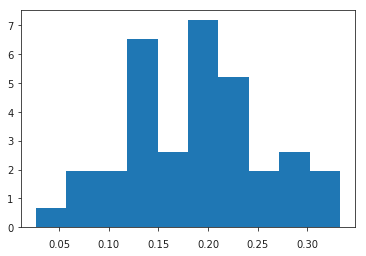

In [18]:
plt.hist(fraction_dist, normed=True)

In [19]:
print "How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([x for x in fraction_dist if x >= (0.392857142857)]) + 1)/(len(fraction_dist) + 1))

How many simulations resulting in a higher infection rate due to hiring? 0.0196078431373


## Load Cached Simulations of Null Model

The above simulation was run 10,000 times to generate the three pickles in this folder: `deep_learning.p`, `incremental.p`, and `topic_modeling.p`. 

Let's load them in here. First, checking "incremental computation":

In [20]:
import cPickle
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/incremental.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [21]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [22]:
real_infection_rate = 0.392857142857 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.193805365345
How many simulations resulting in a higher infection rate due to hiring? 0.001099890011


Next, checking "topic modeling":

In [23]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/topic_modeling.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [24]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [25]:
real_infection_rate = 0.325581395349 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.224871459028
How many simulations resulting in a higher infection rate due to hiring? 0.010398960104


Finally, check "deep learning":

In [26]:
with open("/Users/allisonmorgan/Code/src/github.com/allisonmorgan/epistemic_inequality/publications/deep_learning.p", "rb") as input_file:
    x = cPickle.load(input_file)

In [27]:
print("How many simulations have been run? {0}".format(len(x)))

How many simulations have been run? 10000


In [28]:
real_infection_rate = 0.336134453782 # From "For all universities" section above
print("What is the average infection due to hiring under model? {0}".format(sum(x)/len(x)))
print("How many simulations resulting in a higher infection rate due to hiring? {0}".format((len([i for i in x if i >= real_infection_rate]) + 1)/(len(x) + 1)))

What is the average infection due to hiring under model? 0.302162023439
How many simulations resulting in a higher infection rate due to hiring? 0.166583341666
